#구글 코랩에 데이터셋(가위바위보) 내려받기

In [1]:
# 가위바위보 데이터셋 로드
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=False)
train_dataset_original = dataset['train']
test_datasets = dataset['test']

In [2]:
# 훈련 및 검증 데이터셋 split 비율 설정
train_size = 0.85
train_count = int(info.splits['train'].num_examples * train_size)
valid_count = info.splits['train'].num_examples - train_count

In [3]:
# 훈련 데이터셋과 검증 데이터셋으로 나누기
train_datasets = train_dataset_original.take(train_count)
valid_datasets = train_dataset_original.skip(train_count)

In [4]:
# 각 데이터 셋 크기 확인
print(len(train_datasets))
print(len(valid_datasets))
print(len(test_datasets))

2142
378
372


In [5]:
# 훈련 데이터의 이미지 shpae와 label 확인
for data in train_datasets.take(5):
  print(data['image'].shape)
  print(data['label'])

(300, 300, 3)
tf.Tensor(2, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(2, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(0, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(1, shape=(), dtype=int64)
(300, 300, 3)
tf.Tensor(0, shape=(), dtype=int64)


# 데이터 전처리

In [6]:
# 데이터 전처리 함수 생성
def preprocessing(data):
  image = tf.cast(data['image'], tf.float32) / 255.0
  label = data['label']
  return image, label

In [7]:
# 배치 사이즈 지정, 전처리 함수를 datasets에 매핑
BATCH_SIZE=32
train_data = train_datasets.map(preprocessing).shuffle(1000).batch(BATCH_SIZE)
valid_data = valid_datasets.map(preprocessing).batch(BATCH_SIZE)
test_data = test_datasets.map(preprocessing).batch(BATCH_SIZE)

# 모델 만들기

In [8]:
# 모델 만들기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(300, 300, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
#모델 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856 

In [10]:
# 모델 컴파일. 옵티마이저인 adam의 학습률 변경
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) # Adam의 기본 learning rate 1e-3 -> 5e-5
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics="accuracy")

# 모델 훈련하기, 평가하기

In [11]:
# 콜백함수 및 훈련
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3)
]
history = model.fit(
    train_data,
    validation_data=(valid_data),
    epochs=30,
    callbacks=callbacks)

Epoch 1/30
67/67 [==============================] - 36s 250ms/step - loss: 1.0047 - accuracy: 0.5378 - val_loss: 0.7877 - val_accuracy: 0.7381
Epoch 2/30
67/67 [==============================] - 8s 112ms/step - loss: 0.4987 - accuracy: 0.8193 - val_loss: 0.3370 - val_accuracy: 0.8466
Epoch 3/30
67/67 [==============================] - 8s 108ms/step - loss: 0.1540 - accuracy: 0.9594 - val_loss: 0.0771 - val_accuracy: 0.9815
Epoch 4/30
67/67 [==============================] - 8s 109ms/step - loss: 0.0575 - accuracy: 0.9879 - val_loss: 0.0352 - val_accuracy: 0.9921
Epoch 5/30
67/67 [==============================] - 8s 109ms/step - loss: 0.0337 - accuracy: 0.9916 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 6/30
67/67 [==============================] - 7s 105ms/step - loss: 0.0212 - accuracy: 0.9958 - val_loss: 0.0349 - val_accuracy: 0.9894
Epoch 7/30
67/67 [==============================] - 8s 111ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch

<Figure size 640x480 with 0 Axes>

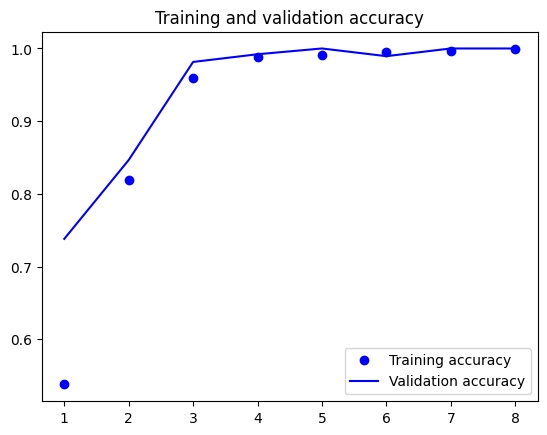

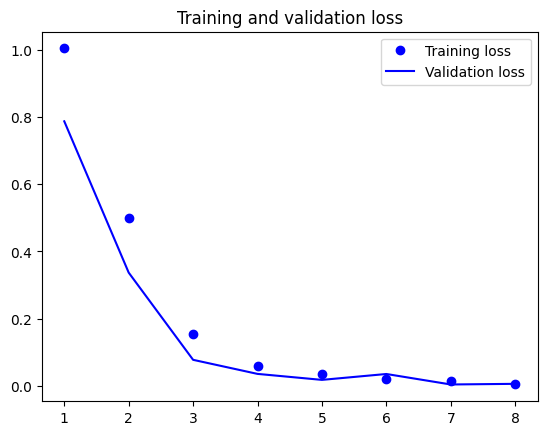

<Figure size 640x480 with 0 Axes>

In [12]:
# 훈련 과정 정확도, 손실 그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()

In [13]:
# 테스트 세트에서 모델 평가하기
import time

test_model = keras.models.load_model("convnet_from_scratch.keras")
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_data)
end_time = time.time()
predict_time = end_time - start_time
print(f"테스트 정확도: {test_acc:.3f}")
print(f"predict time : {predict_time:.3f} s")

12/12 [==============================] - 2s 145ms/step - loss: 0.3849 - accuracy: 0.8226
테스트 정확도: 0.823
predict time : 2.864 s
